In [20]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy
from scipy.spatial import cKDTree
from scipy.optimize import basinhopping
import copy
from sklearn.cluster import MiniBatchKMeans

In [21]:
#real parameters
G_fixed = {
    "thresh": 0.00002,
    "dt": 0.005, #sampling frequency
    "sigma": 10,
    "beta": 1.5,
    "rho": 40,
    "alpha": 1e-4,
    "length": #int(1e06 + 1)
              int(1e05)
              #int(1e04)
    # Trajectory Length
    
}
G = copy.deepcopy(G_fixed)
#new params
def change_param(new, param = "beta"):
    G[param] = new
    return G

# Define the Lorenz-63 System
#@jax.jit
def Lorenz(y, G):
    dx1 = G["sigma"] * (y[1] - y[0])
    dx2 = y[0] * (G["rho"] - y[2]) - y[1]
    dx3 = y[0] * y[1] - G["beta"] * y[2]
    f = np.array((dx1, dx2, dx3), dtype = object).flatten()#.reshape(3, 1)
    return f

# Set initial values and parameters
start = np.array((1., 1., 1.))#.reshape(3, 1)
nt = 1 #transition step size
subset_size = 300 #cell number

def Euler(G):
    y = start
    ys = np.zeros((G["length"],3))
    for timestep in range(G["length"]): 
        
        y = y + G["dt"] * Lorenz(y, G)
        #print(y)
        ys[timestep] = np.array(y)
        #ys[timestep] = y
    
    return ys.transpose()
# def Euler(G):
#     y = start
#     #ys = jnp.zeros((G["length"],3))
#     ys = []
#     for timestep in range(G["length"]): 
        
#         y = y + G["dt"] * Lorenz(y, G)

#         ys.append(y)

    
#     return np.array(ys,dtype=object).transpose()

In [22]:
#REAL trajectory
ys_fixed = Euler(G_fixed)



In [23]:
#CELL CENTER
Xtrain_fixed = ys_fixed.transpose()
sample = MiniBatchKMeans(n_clusters=subset_size).fit(Xtrain_fixed).cluster_centers_

In [24]:

#contruct Markov matrix

# def Markov(ys, sample):
#     point_idxs = []
#     for i in range(G["length"]):
#         Xtrain = ys.transpose()
#         distances = jnp.linalg.norm(sample - Xtrain[i], axis = 1)
#         idxs = jnp.argmin(distances)
#         point_idxs.append(idxs)
    
#     point_idxs = jnp.array(point_idxs)    

#     #print(len(point_idxs))

#     lp = len(point_idxs)

#     transitions = point_idxs[nt:lp] - point_idxs[0:(lp - nt)]
#     cellEdge = jnp.flatnonzero(transitions) + 1

    
#     # Build markov matrix
#     M_mat = jnp.zeros((subset_size, subset_size))
#     for ind in range(0, len(cellEdge) - nt):
#         ce = cellEdge[ind] 
#         M_mat = M_mat.at[point_idxs[ce],point_idxs[ce+nt]].add(1.)
#         #print(point_idxs[ce],point_idxs[ce+nt])

#     # Normalize rows
#     row_sums = jnp.sum(M_mat, axis=1)
#     for i in range(subset_size):
#         if row_sums[i] != 0:
#             M_mat = M_mat.at[:,i].divide(row_sums[i])

#     return M_mat

def Markov(ys, sample):

    tree = cKDTree(sample)
    point_dst, point_idxs = tree.query(ys.transpose()) 
    
    lp = len(point_idxs)

    transitions = point_idxs[nt:lp] - point_idxs[0:(lp - nt)]
    cellEdge = np.flatnonzero(transitions) + 1
    
    # Build markov matrix
    M_mat = np.zeros((subset_size, subset_size))
    for ind in range(0, len(cellEdge) - nt):
        ce = cellEdge[ind] 
        M_mat[point_idxs[ce],point_idxs[ce+nt]] += 1.0

    # Normalize rows
    row_sums = np.sum(M_mat, axis=1)
    for i in range(subset_size):
        if row_sums[i] != 0:
            M_mat[:,i] = M_mat[:,i]/row_sums[i]

    return M_mat

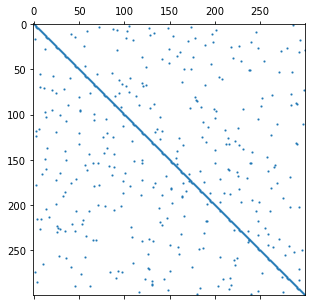

In [25]:
#REAL Markov matrix
M_mat0 = Markov(ys_fixed, sample)

#sanity check of Markov matrix
fig = plt.figure(figsize=(5, 5))
plt.spy(M_mat0, precision=0, marker=None, markersize=1, aspect='equal', origin='upper')

In [26]:
# Creates matrix from trajectory based on parameter

def matrix_original_cells(param):
     return Markov(Euler(change_param(param)), sample)# + noise

def obj_fun_original_traj(params):
    output = []
    for i in range(len(params)):
        output.append(matrix_original_cells(param))
    return jnp.array(output)


#BUILDS MATRIX AND TRANSITIONS WITH A COMBINATION OF TRAJECTORIES
# def matrix_new_cells(param):
#     ys_new = Euler(change_param(param))
#     XTrain_new = jnp.concatenate([ys_fixed, ys_new], axis = 1)
#     Xtrain_new = XTrain_new.transpose()
#     sample_new = MiniBatchKMeans(n_clusters=subset_size).fit(Xtrain_new).cluster_centers_
#     return Markov(ys_new, sample_new)

# def obj_fun_new_traj(params):
#     output = []
#     for param in params:
#         output.append(matrix_new_cells(param))
#     return output

In [27]:
def mat_frobenius_norm(test_mat):
    # return math.sqrt(sum(sum((true_mat - test_mat)**2)))
    return np.linalg.norm(M_mat0 - test_mat)


# def mat_comparison(matrices):
#     norms = []
#     grads = []
#     for new_mat in matrices:
#         norm, grad = jax.value_and_grad(mat_frobenius_norm)(new_mat)
#         norms.append(mat_frobenius_norm(new_mat))
#         grads.append(grad)        
    
#     return norms, grads

# def finite_diff_approx(sigma_values, delta_sigma = 1e-8):
#     approx_grads = []
#     for sigma in sigma_values:
#         true_mat = obj_fun_original_traj([sigma])[0]
#         matrix_plus = obj_fun_original_traj([sigma + delta_sigma])[0]
#         matrix_minus = obj_fun_original_traj([sigma - delta_sigma])[0]
#         mat_plus_norm, _ = mat_comparison(true_mat, matrix_plus)
#         mat_minus_norm, _ = mat_comparison(true_mat, matrix_minus)

#         approx_grad = (mat_plus_norm[0] - mat_minus_norm[0]) / (2 * delta_sigma)
#         approx_grads.append(approx_grad)
#     return approx_grads


#def finite_diff_approx(values, delta_val = 1e-8):

In [28]:
beta_values = np.arange(1, 3, .25)
mat_beta = []
for i in range(len(beta_values)):
    mat_beta.append(mat_frobenius_norm(matrix_original_cells(beta_values[i])))
mat_beta = np.array(mat_beta)

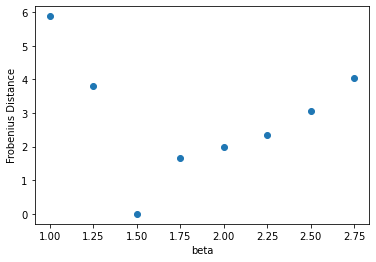

In [29]:
plt.scatter(beta_values, mat_beta)
plt.xlabel("beta")
plt.ylabel("Frobenius Distance")
plt.show()

In [19]:
# PERFORMING TESTS ON COMBINATION OF TRAJECTORIES

# rho_values = np.arange(30, 50, 2.5)
# resulting_mats = obj_fun_new_traj(sigma_values)

# resulting_norms, resulting_grads = mat_comparison(M_mat0, resulting_mats)
# resulting_norms = np.delete(resulting_norms, 15)
# sigma_values = np.delete(sigma_values, 15)
# plt.scatter(sigma_values, resulting_norms)
# plt.xlabel("sigma")
# plt.ylabel('Frobenius distance')
# plt.show()